pip install pandas matplotlib sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
!jq . "COVID-19/dati-json/dpc-covid19-ita-province.json" > "dpc-covid19-ita-province-nobom.json"
!jq . "COVID-19/dati-json/dpc-covid19-ita-regioni.json" > "dpc-covid19-ita-regioni-nobom.json"

In [3]:
ita_province = pd.read_json('dpc-covid19-ita-province-nobom.json')
ita_regioni = pd.read_json('dpc-covid19-ita-regioni-nobom.json')

In [4]:
data = ita_regioni.set_index(['denominazione_regione', 'data']).sort_index().reset_index()
data['data'] = pd.to_datetime(data['data'])
del data['long'], data['lat'], data['stato'], data['codice_regione'], data['nuovi_attualmente_positivi']
del data['totale_attualmente_positivi'], data['totale_ospedalizzati']

In [7]:
def carica_province():
    x = ita_province[['data', 'denominazione_provincia', 'totale_casi']].copy().sort_values(['denominazione_provincia', 'data'])
    x['data'] = pd.to_datetime(x['data'])
    #x['giorno'] = x.groupby('data').ngroup()
    x['nuovi_casi'] = x.groupby('denominazione_provincia').totale_casi.diff()
    x['totale_casi_prec'] = x.groupby('denominazione_provincia').totale_casi.shift()
    x['crescita'] = x['nuovi_casi'] / x['totale_casi_prec']

    x = x[x['denominazione_provincia'] != 'In fase di definizione/aggiornamento']
    
    x = x.replace([np.inf, -np.inf], np.nan).dropna()
    
    return x

In [8]:
dati_province = carica_province()

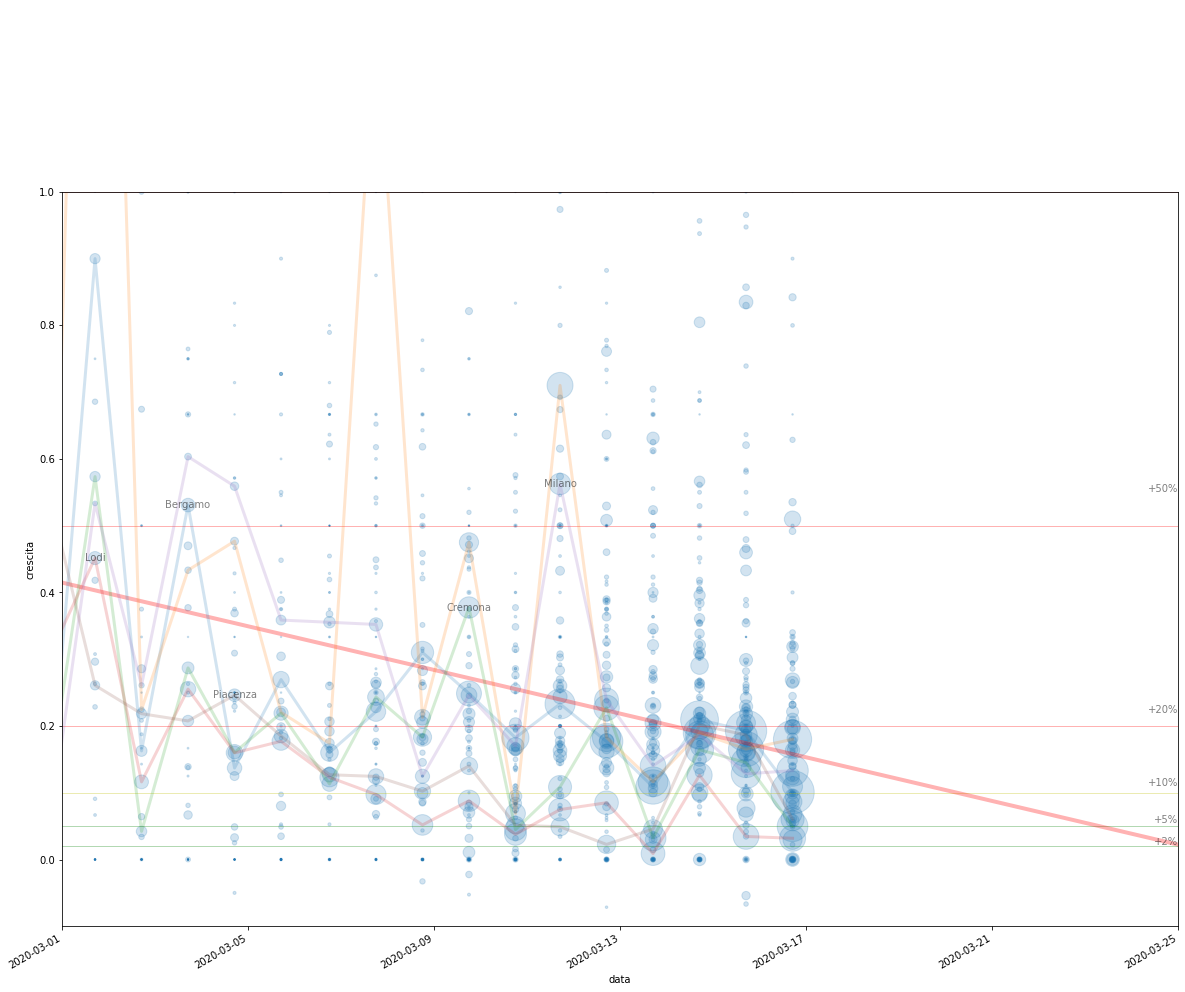

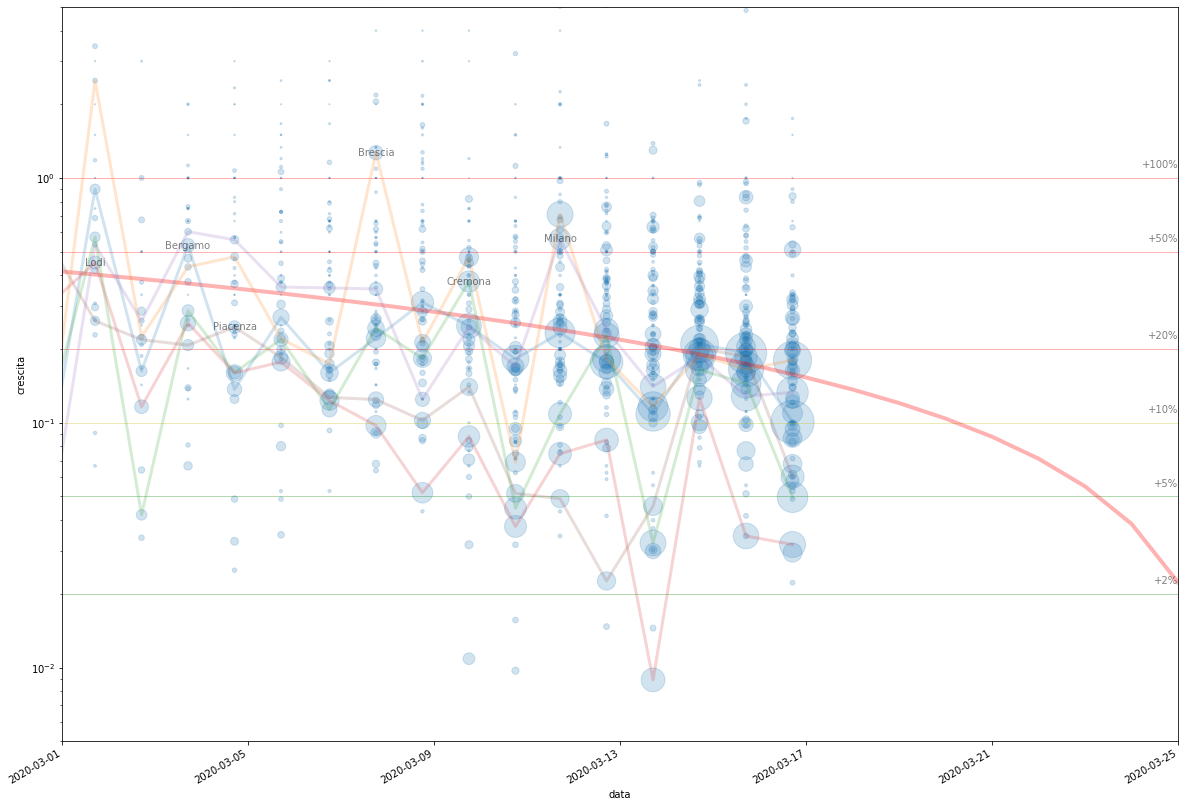

In [9]:
xlim_date = [pd.to_datetime('2020-03-01'), pd.to_datetime('2020-03-25')]
xlim = [d.to_datetime64() for d in xlim_date]

for logy in [False, True]:
    if logy:
        ylim = (0.005, 5)
    else:
        ylim = (-0.1, 1)

    dati_province.plot.scatter(
        'data', 'crescita', 
        s=0.5*dati_province['totale_casi'], 
        alpha=0.2, 
        logy=logy, 
        ylim=ylim, 
        figsize=(20, 20),
    )

    ax = plt.gca()

    for coeff, style in [
        [1.00, 'r'],
        [0.50, 'r'],
        [0.20, 'r'],
        [0.10, 'y'],
        [0.05, 'g'],
        [0.02, 'g'],
    ]:
        ax.plot(xlim, [coeff, coeff], style, linewidth=1, alpha=0.3)
        ax.annotate(f"+{coeff * 100:.0f}%", (xlim[1], coeff * 1.1), alpha=0.5, ha='right')

    train = dati_province[['data', 'crescita', 'totale_casi']].copy()
    train['secondi'] = (train['data'] - xlim_date[0]).dt.total_seconds()

    regr = LinearRegression()
    regr.fit(
        train['secondi'].values.reshape(-1, 1), 
        train['crescita'].values.reshape(-1, 1), 
        train['totale_casi'].values,
    )

    # regr2 = LinearRegression()
    # regr2.fit(
    #     train['secondi'].values.reshape(-1, 1), 
    #     np.log(train['crescita'].clip(0.001, None).values.reshape(-1, 1)), 
    #     train['totale_casi'].values,
    # )

    dr = pd.date_range(*xlim_date).to_series()

    pred_crescita = pd.Series(regr.predict((dr - pd.to_datetime('2020-03-01')).dt.total_seconds().values.reshape(-1, 1))[:,0], index=dr)
    pred_crescita.plot(c='r', linewidth=4, alpha=0.3)

    # pred_crescita2 = pd.Series(np.exp(regr2.predict((dr - pd.to_datetime('2020-03-01')).dt.total_seconds().values.reshape(-1, 1)))[:,0], index=dr)
    # pred_crescita2.plot(c='r', linewidth=4, alpha=0.3)

    for provincia, d in dati_province.groupby('denominazione_provincia'):
        if not d['totale_casi'].iloc[-1] > 1000:
            continue

        d = d.copy().set_index('data', drop=False)
        d['crescita'].where(d['crescita'] > 0).plot(
            xlim=xlim,
            ylim=ylim, 
            figsize=(20, 15), 
            alpha=0.2,
            linewidth=3,
    #         c='k',
        )

        x = d
        x = x[x['data'] > xlim[0]]
        x = x[x['totale_casi'] > 300]
        x = x[x['crescita'] < 100]
        x = x[x['crescita'] == x['crescita'].max()]

        if len(x) == 0:
            continue

        x = x.iloc[0]

        if 0.001 <= x['crescita']:
            ax.annotate(provincia, (x['data'].to_datetime64(), x['crescita']), c='k', va='center', ha='center', alpha=0.5)

/home/cairomassimo/.virtualenvs/covid19/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/cairomassimo/.virtualenvs/covid19/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/cairomassimo/.virtualenvs/covid19/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax

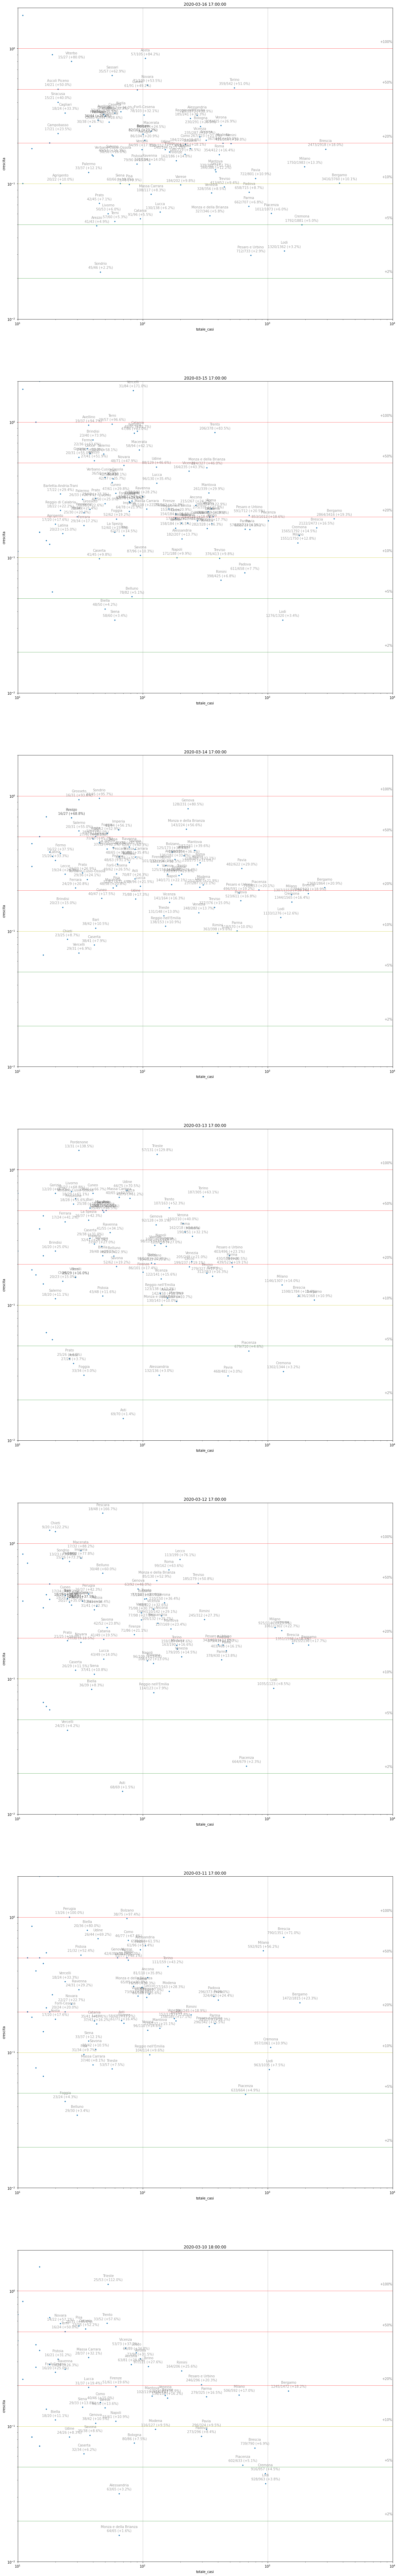

In [10]:
groups = list(dati_province[dati_province['data'] > '2020-03-10'].groupby('data'))
groups.reverse()
fig, axes = plt.subplots(len(groups), 1, figsize=(20, 20 * len(groups)), sharey=True)

ylim = [0.01, 2]

for (d, g), ax in zip(groups, axes):
    ax.set_title(f"{d}")

    data = g.set_index('denominazione_provincia')

    ax.set_yscale('log')
    ax.set_xscale('log')
    data.plot.scatter('totale_casi', 'crescita', marker='+', xlim=(1e1, 1e4), ylim=ylim, loglog=True, ax=ax)

    for casi in [1e2, 1e3]:
        ax.plot([casi, casi], ylim, 'k', linewidth=1, alpha=0.2)

    for coeff, style in [
        [1.00, 'r'],
        [0.50, 'r'],
        [0.20, 'r'],
        [0.10, 'y'],
        [0.05, 'g'],
        [0.02, 'g'],
    ]:
        ax.plot([1, 1e5], [coeff, coeff], style, linewidth=1, alpha=0.5)
        ax.annotate(f"+{coeff * 100:.0f}%", (1e4, coeff * 1.1), alpha=0.5, ha='right')

    for provincia in data.index:
        x, y = data.totale_casi[provincia], data.crescita[provincia]

        if x >= 20 and y > 0 and data.crescita[provincia] > 0.01:
            ax.annotate(
                f"{provincia}\n{int(data.totale_casi_prec[provincia])}/{data.totale_casi[provincia]} (+{data.crescita[provincia]*100:.1f}%)",
                (x, y * 1.05),
                alpha=0.4, rotation=0, rotation_mode='anchor', va='bottom', ha='center', ma='center',
            )

In [ ]:
r = data.groupby('data').sum()
r.plot(style='o-', figsize=(10, 6), logy=True, ylim=(1, 1e6))
plt.gca().set_title('Totale')
r.diff().plot(style='o-', figsize=(10, 10), logy=True, ylim=(1, 1e6))
plt.gca().set_title('Totale crescita')

In [ ]:
for k, r in data.groupby('denominazione_regione'):
    r.set_index('data').plot(style='o-', figsize=(10, 10), logy=True, ylim=(1, 1e5))
    plt.gca().set_title(k)
    r.drop(columns='denominazione_regione').set_index('data').diff().plot(style='o-', figsize=(10, 10), logy=True, ylim=(1, 1e5))
    plt.gca().set_title(k + ' crescita')